# 03. Model Inference & Advanced Evaluation (XGBoost Focus)

This notebook performs a **Deep Dive Evaluation** of the trained Standalone XGBoost model.

**Visualization Suite:**
- 📈 **Time-Series Analysis**: Actual vs Predicted (Global & Multi-Zoom)
- 🎯 **Accuracy Plots**: Regression Scatter & Residual Analysis
- 📊 **Distribution**: Error Histograms & Boxplots
- 🌟 **Feature Importance**: Top contributors to the model
- 📋 **Metrics Table**: Comprehensive performance summary

In [5]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set Style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (15, 7)

# Add project root
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))

from src.models import load_model_from_dir

## 1. Load Data for Evaluation

In [6]:
data_path = project_root / 'data' / 'features.parquet'
if not data_path.exists():
    raise FileNotFoundError("Features file not found. Please run Notebook 02 first.")

df = pd.read_parquet(data_path).sort_values('number')

# Using last 20% as test set (consistent with training)
test_split = int(len(df) * 0.8)
test_df = df.iloc[test_split:].copy()
print(f"Dataset Size: {len(df)}")
print(f"Test Set Size: {len(test_df)} samples")

Dataset Size: 9994
Test Set Size: 1999 samples


## 2. Advanced Evaluation Function
This function generates a full report for any trained model.

In [7]:
def analyze_model(model_dir, model_name="XGBoost Model"):
    path = project_root / model_dir
    if not path.exists():
        print(f"⚠️  {model_name} not found at {path}. Skipping.")
        return
    
    print(f"\n{'='*80}")
    print(f"🔍 ANALYZING: {model_name}")
    print(f"{'='*80}\n")
    
    # --- 1. Load Model ---
    model, metadata = load_model_from_dir(path)
    scaler = joblib.load(path / 'scaler.pkl')
    
    # Get Features
    feature_cols = metadata.get('feature_names')
    if not feature_cols:
         with open(path / 'training_info.json', 'r') as f:
             feature_cols = json.load(f)['feature_columns']
    
    # Prepare Test Data
    X_test = test_df[feature_cols].values
    y_test = test_df['baseFee_next'].values
    # Normalize features
    X_test_scaled = scaler.transform(X_test)
    
    # Inference
    y_pred = model.predict(X_test_scaled)
    
    # --- Robust unit detection & normalization ---
    # We treat Wei as the canonical internal unit for metrics.
    y_test_arr = np.asarray(y_test).astype(float)

    min_v, max_v, median_v = y_test_arr.min(), y_test_arr.max(), np.median(y_test_arr)
    print(f"DEBUG units check -> min: {min_v:.3e}, median: {median_v:.3e}, max: {max_v:.3e}")

    # Heuristics:
    # - If max > 1e6 => likely values are in Wei (because even 0.001 Gwei = 1e6 Wei)
    # - If max < 1e6  => likely values already in Gwei
    if max_v > 1e6:
        print("ℹ️ Detected input units = Wei (values large). Using Wei as internal unit.")
        y_test_wei = y_test_arr.copy()
        y_pred_wei = np.asarray(y_pred).astype(float)
    else:
        print("ℹ️ Detected input units = Gwei (values small). Converting to Wei for internal metrics.")
        # convert Gwei -> Wei for canonical internal metrics
        y_test_wei = y_test_arr * 1e9
        y_pred_wei = np.asarray(y_pred).astype(float) * 1e9

    # For plotting/presentation use Gwei (more readable)
    unit_label = 'Gwei'
    y_test_plot = y_test_wei / 1e9
    y_pred_plot = y_pred_wei / 1e9
    
    # --- 2. Calculate Metrics ---
    # Use y_test_wei and y_pred_wei for metric computations below (MAE, RMSE, etc.)
    mask = y_test_wei != 0 # Avoid division by zero
    mape = np.mean(np.abs((y_test_wei[mask] - y_pred_wei[mask]) / y_test_wei[mask])) * 100
    mse = mean_squared_error(y_test_wei, y_pred_wei)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_wei, y_pred_wei)
    r2 = r2_score(y_test_wei, y_pred_wei)
    
    # Check Under-estimation (Critical for Gas)
    residuals = y_test_wei - y_pred_wei
    under_estimations = residuals[residuals > 0]
    over_estimations = residuals[residuals < 0]
    under_est_rate = len(under_estimations) / len(residuals) * 100
    
    # Display Metrics Table
    metrics_df = pd.DataFrame({
        'Metric': ['MAE (Wei)', 'MAE (Gwei)', 'RMSE (Wei)', 'RMSE (Gwei)', 'MAPE (%)', 'R2 Score', 'Under-est Rate (%)'],
        'Value': [mae, mae/1e9, rmse, rmse/1e9, mape, r2, under_est_rate]
    })
    print("📊 Performance Metrics:")
    display(metrics_df.style.background_gradient(cmap='Greens', subset=['Value']))
    
    # --- 3. Visualizations ---
    # Layout: 
    # Row 1: Global Plot
    # Row 2: 3 Zoomed Windows (Start, Middle, End)
    # Row 3: Scatter & Residuals
    
    fig = plt.figure(figsize=(24, 18))
    gs = fig.add_gridspec(3, 3)
    
    # Plot A: Time Series (Global)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(y_test_plot, label='Actual BaseFee', alpha=0.6, color='#1f77b4', linewidth=1)
    ax1.plot(y_pred_plot, label='Predicted BaseFee', alpha=0.8, color='#ff7f0e', linestyle='--', linewidth=1)
    ax1.set_title(f'Global Prediction Performance ({unit_label}) - R2: {r2:.4f}', fontsize=16, fontweight='bold')
    ax1.set_ylabel(f'Gas Fee ({unit_label})')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # --- Zoom Windows: Generate "Non-Flat" Examples ---
    # We pick 3 windows: Beginning, Middle, and End of the test set
    window_size = 100
    total_len = len(y_test_plot)
    
    # Safe indices
    start_idx = 0
    mid_idx = total_len // 2
    end_idx = max(0, total_len - window_size)
    
    windows = [
        (start_idx, start_idx + window_size, "Start of Test Set"),
        (mid_idx, mid_idx + window_size, "Middle of Test Set"),
        (end_idx, total_len, "End of Test Set (Latest)")
    ]
    
    for i, (s, e, title) in enumerate(windows):
        ax_zoom = fig.add_subplot(gs[1, i])
        # Ensure slice is valid
        if s < total_len:
            actual_slice = y_test_plot[s:e]
            pred_slice = y_pred_plot[s:e]
            
            ax_zoom.plot(range(s, e), actual_slice, label='Actual', marker='o', markersize=3, color='#1f77b4', alpha=0.7)
            ax_zoom.plot(range(s, e), pred_slice, label='Predicted', marker='x', markersize=3, color='#ff7f0e', linestyle='--')
            
            ax_zoom.set_title(f'Zoom: {title}', fontsize=12)
            ax_zoom.set_ylabel(f'{unit_label}')
            ax_zoom.set_xlabel('Sample Index')
            if i == 0: ax_zoom.legend()
            ax_zoom.grid(True, alpha=0.3)

    # Plot C: Regression Scatter Plot
    ax3 = fig.add_subplot(gs[2, 0])
    # Downsample for scatter if too large
    scatter_mask = np.random.choice([True, False], size=len(y_test_plot), p=[min(1.0, 1000/len(y_test_plot)), 1-min(1.0, 1000/len(y_test_plot))])
    sns.regplot(x=y_test_plot[scatter_mask], y=y_pred_plot[scatter_mask], ax=ax3, scatter_kws={'alpha':0.3, 's':10}, line_kws={'color':'red'})
    ax3.set_title('Actual vs Predicted Correlation (Sampled)', fontsize=12)
    ax3.set_xlabel(f'Actual ({unit_label})')
    ax3.set_ylabel(f'Predicted ({unit_label})')
    
    # Plot D: Residual Distribution
    ax4 = fig.add_subplot(gs[2, 1])
    residuals_plot = y_test_plot - y_pred_plot
    sns.histplot(residuals_plot, kde=True, ax=ax4, color='purple', bins=50)
    ax4.axvline(0, color='red', linestyle='--')
    ax4.set_title(f'Error Distribution', fontsize=12)
    ax4.set_xlabel(f'Error ({unit_label})')
    
    # Plot E: Error vs Magnitude
    ax5 = fig.add_subplot(gs[2, 2])
    ax5.scatter(y_test_plot[scatter_mask], residuals_plot[scatter_mask], alpha=0.3, s=10, c=residuals_plot[scatter_mask], cmap='coolwarm')
    ax5.axhline(0, color='black', linestyle='--')
    ax5.set_title('Residuals vs Magnitude', fontsize=12)
    ax5.set_xlabel(f'Actual ({unit_label})')
    
    plt.tight_layout()
    plt.show()
    
    # --- 4. Feature Importance (XGBoost Specific) ---
    try:
        # Resolve the underlying XGBoost model
        if hasattr(model, 'model') and model.model is not None:
             booster = model.model
        else:
             booster = model

        plt.figure(figsize=(12, 8))
        got_importance = False
        
        # 1. Try feature_importances_ (sklearn API)
        if hasattr(booster, 'feature_importances_'):
             importances = booster.feature_importances_
             if len(importances) == len(feature_cols):
                 fi_df = pd.DataFrame({'Feature': feature_cols, 'Importance': importances})
                 got_importance = True
        
        # 2. If that failed, try get_booster().get_score() (native API)
        if not got_importance and hasattr(booster, 'get_booster'):
             b = booster.get_booster()
             importances_dict = b.get_score(importance_type='gain')
             fi_df = pd.DataFrame({
                 'Feature': list(importances_dict.keys()), 
                 'Importance': list(importances_dict.values())
             })
             # If features are just f0, f1... try to map them if count matches
             if len(feature_cols) == len(fi_df):
                 # This is a best-effort mapping
                 fi_df['Feature'] = feature_cols
                 
             got_importance = True

        if got_importance:
            fi_df = fi_df.sort_values('Importance', ascending=False).head(20)
            sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
            plt.title('Top 20 Feature Importance (Gain)', fontsize=14)
            plt.xlabel('Importance Score')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        else:
             print("ℹ️ Feature importance not available for this model structure.")

    except Exception as e:
        print(f"⚠️ Could not plot feature importance: {e}")

## 3. Run Analysis


🔍 ANALYZING: Standalone XGBoost (models/xgboost_notebook)

DEBUG units check -> min: 1.242e+08, median: 1.653e+08, max: 5.880e+08
ℹ️ Detected input units = Wei (values large). Using Wei as internal unit.
📊 Performance Metrics:


,Metric,Value
0,MAE (Wei),7013695.989495
1,MAE (Gwei),0.007014
2,RMSE (Wei),8359048.276974
3,RMSE (Gwei),0.008359
4,MAPE (%),4.047894
5,R2 Score,0.984696
6,Under-est Rate (%),12.456228


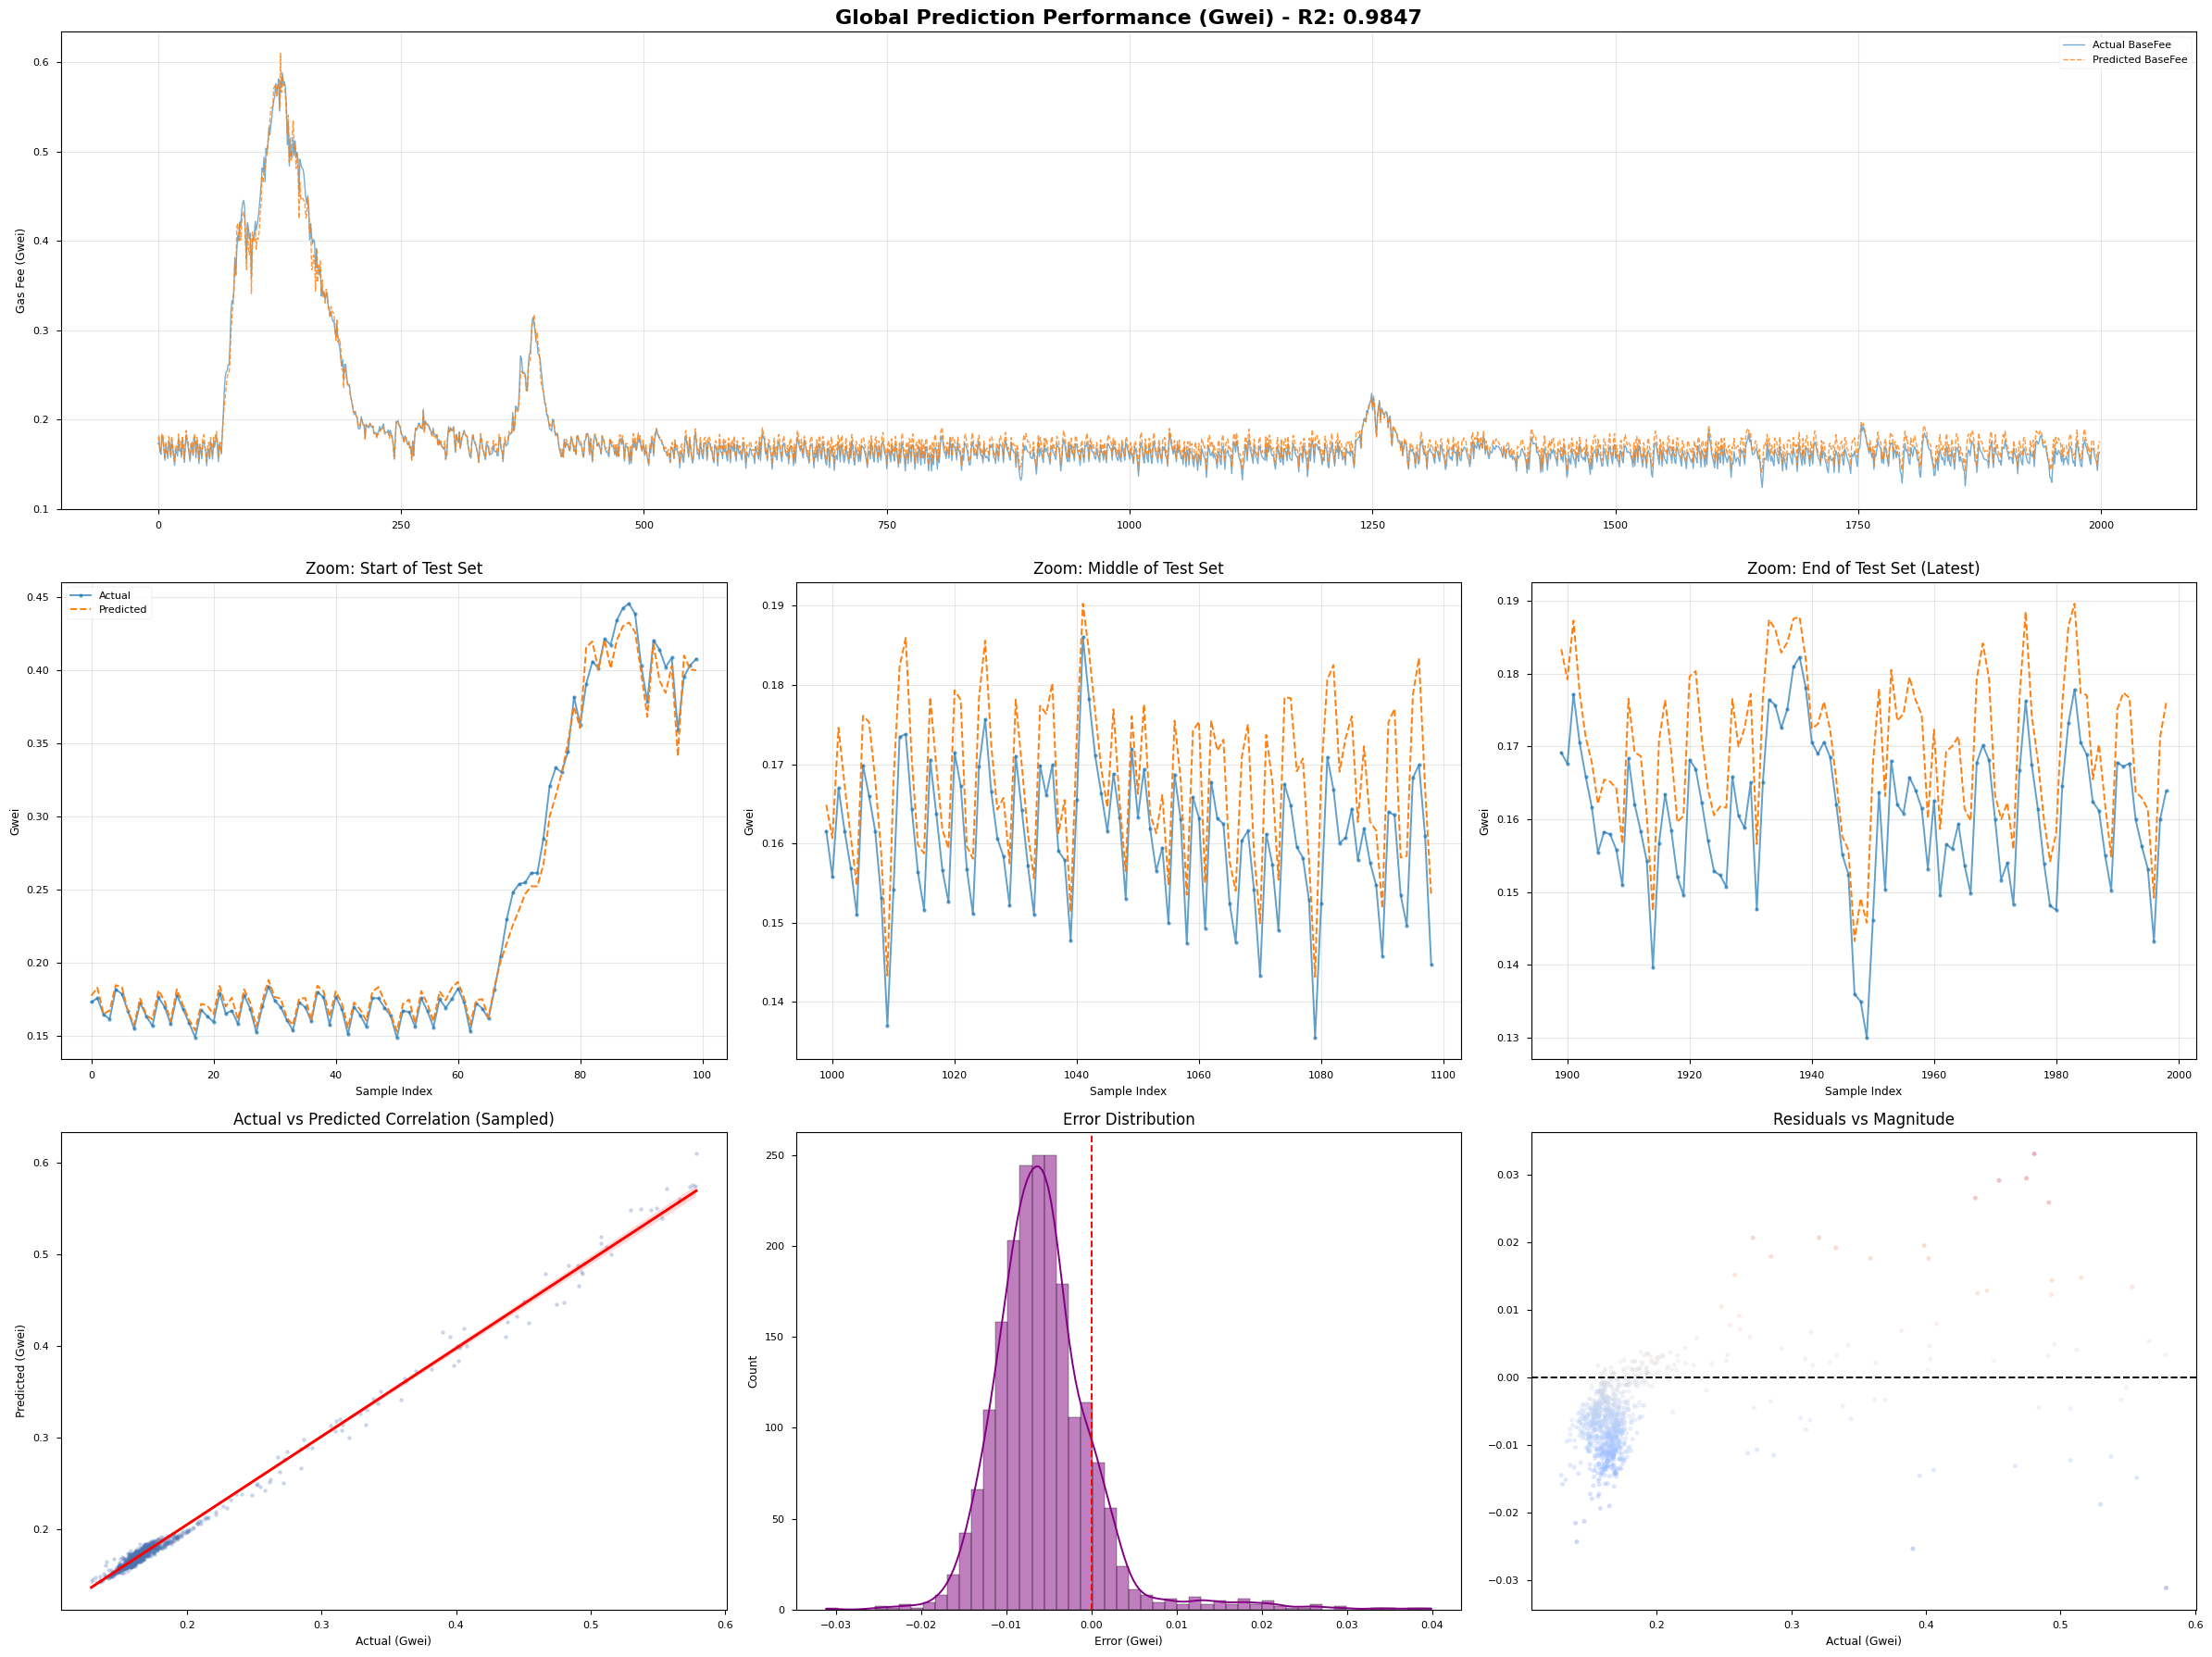

C:\Users\Vanszs\AppData\Local\Temp\ipykernel_21180\2450958031.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')


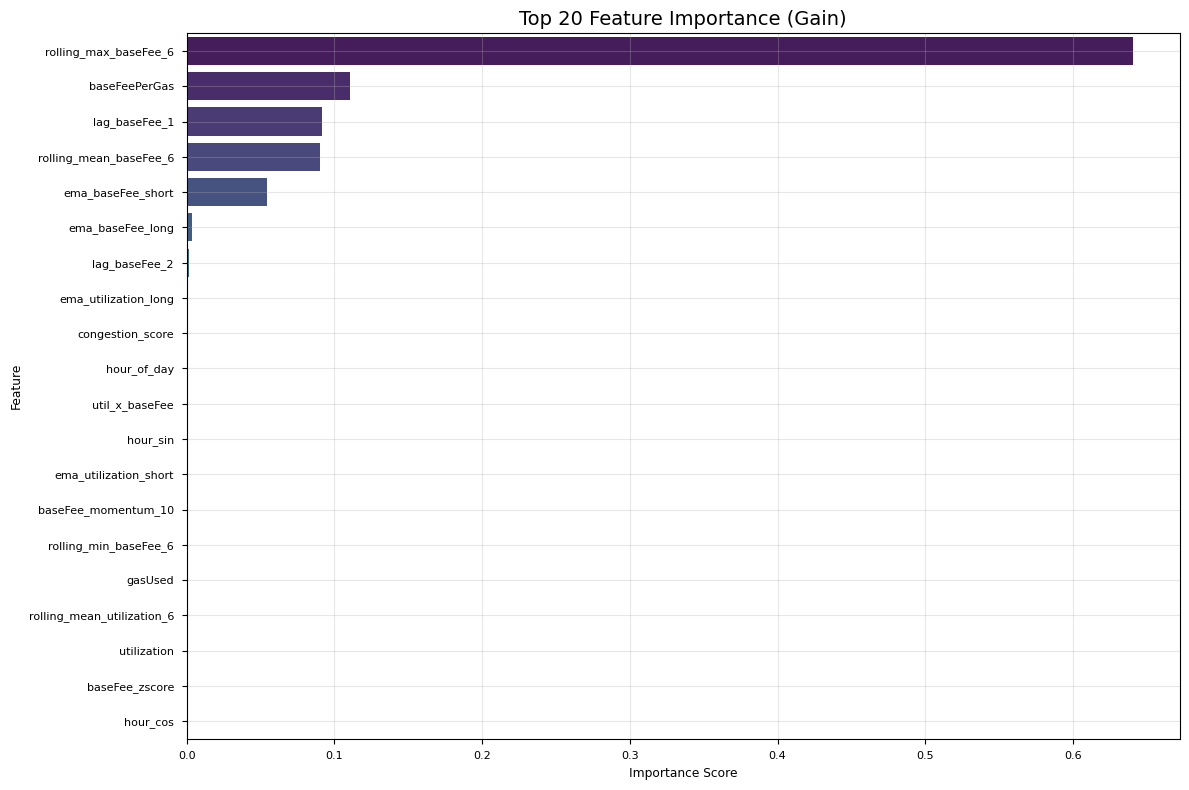

In [8]:
# Run Analysis for Default Model
model_paths = ['models/xgboost_notebook', 'models/xgboost_robust', 'models/xgboost']
found = False

for p in model_paths:
    path = project_root / p
    if path.exists():
        analyze_model(p, f"Standalone XGBoost ({p})")
        found = True
        break

if not found:
    print(f"❌ Could not find model in typical locations: {model_paths}")
    print("Please train the model first using: python src/train_xgb.py")